## 자료 가져오기

In [1]:
# 영상처리에 있어서 핵심적인 matplotlib과 opencv , numpy 가져오기
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
if not os.path.exists("len_top.jpg"):
    # 영상처리에 있어서 가장 많이 이용되는 Lena 이미지 활용하기
    !wget http://www.lenna.org/len_top.jpg

## Objective

1. 사상(mapping)에 대한 이해
2. 양방향 선형 보간법(Bilinear Interpolation)에 대한 이해
3. `cv2.resize`이용하기

<h1 style = "background-color: rgba(185, 109, 106, 0.3);" > 기하학 처리란?</h1>

> 영상 처리에서 기하학 처리는 영상 내에 있는 기하학적인 대상의 공간적 배치를 변경하는 과정이다. 이것을 화소의 입장에서 보면, 영상을 구성하는 화소들의 공간적 위치를 재배치하는 과정이다. 이러한 재배치를 담당하는 함수를 mapping 함수라 하고, 모든 기하학 처리는 어떤 mapping 함수를 이용하는 가에 달려 잇다.

---
## 1. mapping이란

> 기하학적 처리의 기본은 화소들의 배치를 변경. 화소의 배치를 변경하려면 사상(mapping)이라는 의미를 이해해야 한다. 사상은 화소들의 배치를 변경할 때, 입력영상의 좌표가 새롭게 배치될 해당 목적영상의 좌표를 찾아서 화소값을 옮기는 과정이다.

### 1) 순방향 사상

![](../misc/순방향 사상.png)

순방향 사상은 원본 영상의 좌표를 중심으로 목적영상의 좌표를 계산하여 화소의 위치를 변환하는 방식이다. 이럴 경우 hole과 overlap의 문제가 발생할 수 있다. 홀은 입력영상의 좌표들로 목적 영상의 좌표를 만드는 과정에서 사상되지 않은 화소를 가리킨다. 보통 영상을 확대하거나 회전할 때에 발생한다. 반면, 오버랩은 영상을 축소할 때 주로 발생한다. 이것은 원본 영상의 여러 화소가 목적 영상의 한 화소로 사상되는 것을 말한다. 

### 예제) 순방향 사상을 통해, 이미지를 2배로 키워보기

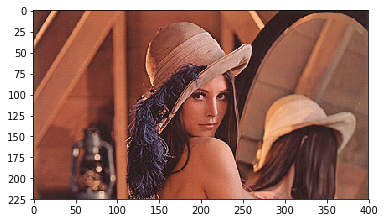

In [2]:
image = cv2.imread("./len_top.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

In [3]:
height,width = image.shape[:2]
target_image = np.zeros((int(height*2),int(width*2),3),np.uint8)

xs, ys = np.meshgrid(np.arange(width), np.arange(height))

for x,y in zip(xs.ravel(), ys.ravel()):
    target_y = np.clip(2*y, 0, target_image.shape[0]-1).astype(np.int)
    target_x = np.clip(2*x, 0, target_image.shape[1]-1).astype(np.int)
    
    
    target_image[target_y, target_x] = image[y,x]

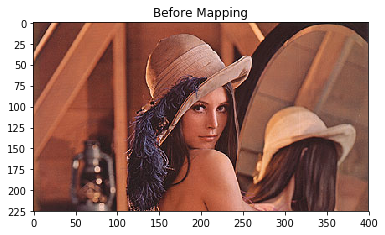

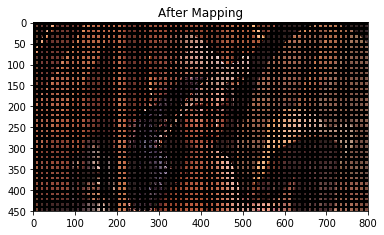

In [4]:
plt.title("Before Mapping")
plt.imshow(image)
plt.show()

plt.title("After Mapping")
plt.imshow(target_image)
plt.show()

검은 부분들이 모두 hole이라고 생각하면 된다. 기본적으로 순방향 사상은 거의 쓰지 않는 방식이다. 

### 2) 역방향 사상

![](../misc/역방향 사상.png)

역방향 사상은 목적영상의 좌표를 중심으로 역변환을 계산하여 해당하는 입력 영상의 좌표를 찾아서 화값을 가져오는 방식이다. 역방향 사상의 방식은 홀이나 오버랩은 발생하지 않는다. 

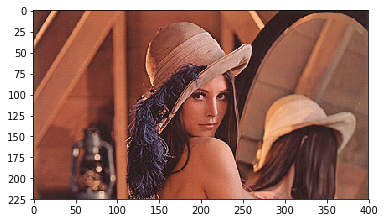

In [5]:
image = cv2.imread("./len_top.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

### 예제) 역방향 사상을 통해, 이미지를 2배로 키워보기

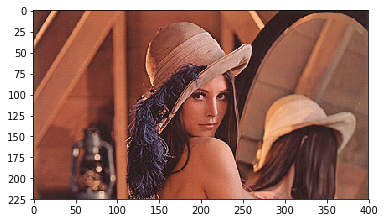

In [6]:
image = cv2.imread("./len_top.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

In [7]:
height,width = image.shape[:2]
target_image = np.zeros((int(height*2),int(width*2),3),np.uint8)
t_height, t_width = target_image.shape[:2]

xs, ys = np.meshgrid(np.arange(t_width), np.arange(t_height))

for target_x, target_y in zip(xs.ravel(), ys.ravel()):
    origin_y = np.clip(target_y/2, 0, height-1).astype(np.int)
    origin_x = np.clip(target_x/2, 0, width-1).astype(np.int)
    
    target_image[target_y, target_x] = image[origin_y,origin_x]

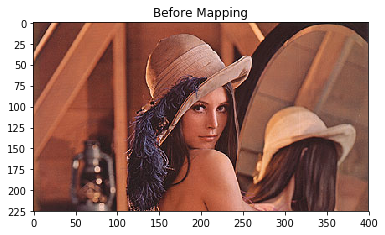

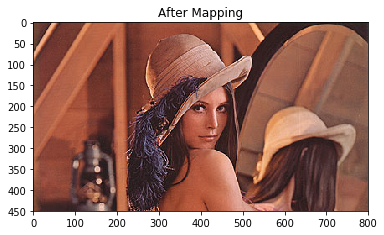

In [8]:
plt.title("Before Mapping")
plt.imshow(image)
plt.show()

plt.title("After Mapping")
plt.imshow(target_image)
plt.show()

---
## 2. 양방향 선형보간법

> 역방향 사상이 위와 같이 기본적으로 깔끔한 방식이다. 홀이나 오버랩이 기본적으로 발생하지 않기 떄문에 훨씬 더 부드럽게 진행된다. 다만, 입력영상의 한 화소를 목적영상의 여러 화소에서 사용하게 되면 결과 영상의 품질이 떨어질 수 있다. 아래와 같이 계단식의 형상이 만들어진다. 이 문제를 극단적으로 보기 위해 영상을 5배로 키워보겠다.

### 예제) 역방향 사상을 통해, 이미지를 5배 키워보기

In [9]:
# 시간이 너무 많이 걸리므로 일부 이미지만 crop해서 하겠음
crop_image = image[50:150,150:250]

height,width = crop_image.shape[:2]
target_image = np.zeros((int(height*5),int(width*5),3),np.uint8)
t_height, t_width = target_image.shape[:2]

xs, ys = np.meshgrid(np.arange(t_width), np.arange(t_height))

for target_x, target_y in zip(xs.ravel(), ys.ravel()):
    origin_y = np.clip(target_y/5, 0, height-1).astype(np.int)
    origin_x = np.clip(target_x/5, 0, width-1).astype(np.int)
    
    target_image[target_y, target_x] = crop_image[origin_y,origin_x]

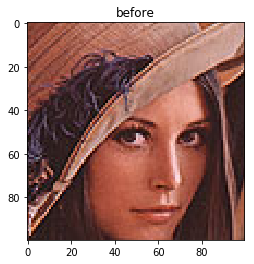

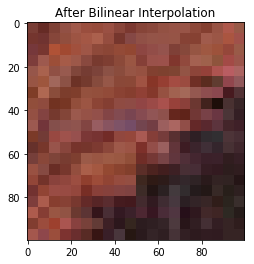

In [10]:
plt.title("before")
plt.imshow(crop_image)
plt.show()

plt.title("After Bilinear Interpolation")
plt.imshow(target_image[100:200,0:100])
plt.show()

자세히 보면 5x5 블럭끼리 완전히 같은 색깔을 가지고 있다. 즉 이미지가 모자이크 형태로 만들어진다. 이것을 보다 부드럽게 보정하기 위해 기본적으로 양선형 보간법(Bilinear Interpolation)을 이용한다. 

### Bilinear Interpolation

![](../misc/양선형 보간법.png)

양선형 보간법은 위와 같이, 선형 보간을 두 번에 걸쳐서 수행하기에 붙여진 이름이다. X축을 기준으로 한번, y축을 기준으로 또 한번 보간함으로써 값을 보정한다

먼저, 목적영상의 화소(P)를 역변환으로 계산하여 가장 가까운 위치에 있는 입력 영상의 4개 화소(A,B,C,D)를 가져온다. 그림과 같이 가져온 4개 화소를 두 개씩(AB,CD) 묶어서 1차적으로 선형 보간(M1,M2)을 취한다. 그리고 M1,M2을 잇는 직선을 다시 구성하고, 두개의 중간 화소값과 거리 비율($\beta$,$1-\beta$)을 바탕으로 선형보간을 통해 최종 화소값(P)를 계산한다. 

### 예제) 양방향 선형 보간법 사상을 통해, 이미지를 5배로 키워보기

In [11]:
# 시간이 너무 많이 걸리므로 일부 이미지만 crop해서 하겠음
crop_image = image[50:150,150:250]

height,width = crop_image.shape[:2]
target_image = np.zeros((int(height*5),int(width*5),3),np.uint8)
t_height, t_width = target_image.shape[:2]

xs, ys = np.meshgrid(np.arange(t_width), np.arange(t_height))

for target_x, target_y in zip(xs.ravel(), ys.ravel()):
    origin_x = target_x/5
    origin_y = target_y/5
    
    min_x = np.floor(origin_x).astype(np.int)
    min_y = np.floor(origin_y).astype(np.int)
    max_x = np.ceil(origin_x).astype(np.int)
    max_y = np.ceil(origin_y).astype(np.int)

    alpha = origin_x - min_x
    beta = origin_y - min_y
    
    if max_x >= width: max_x = width-1
    if max_y >= height: max_y = height-1

    A = crop_image[min_y,min_x].astype(np.float)
    B = crop_image[min_y,max_x].astype(np.float)
    C = crop_image[max_y,min_x].astype(np.float)
    D = crop_image[max_y,max_x].astype(np.float)
    
    M1 = A + alpha*(B-A)
    M2 = C + alpha*(D-C)
    P = M1 + beta*(M2-M1)
    
    target_image[target_y, target_x] = P.astype(np.uint8)

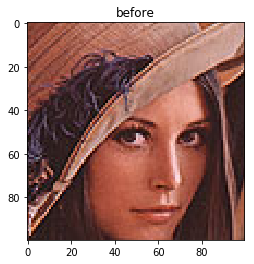

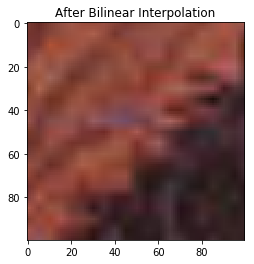

In [12]:
plt.title("before")
plt.imshow(crop_image)
plt.show()

plt.title("After Bilinear Interpolation")
plt.imshow(target_image[100:200,0:100])
plt.show()

모자이크 현상이 사라지고, 훨씬 더 부드럽게 선이 이어진다. 하지만, 이렇게 구현된 경우에(For 구문) 속도가 미친듯이 느리다. 그래서 일반적으로 우리가 이미지를 resize할 때에는, `cv2.resize` 메소드를 이용한다.

----

## 3. `cv2.resize`

> 기본적으로 opencv에서는 이미지의 확대 및 축소를 해주는 resize 메소드가 구현되어 있다. 이는 아래와 같이 동작한다.

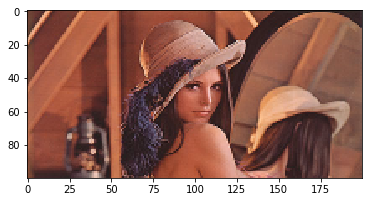

In [13]:
target_height = 100 # 높이를 100 pixel로
target_width = 200 # 가로를 200 pixel로

target = cv2.resize(image,(target_width,target_height))

plt.imshow(target)
plt.show()

이렇게 목표 영상의 크기를 지정할 수 있고, 아래와 같이 배율을 지정할 수도 있다.

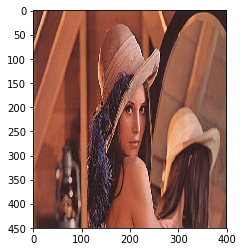

In [14]:
target = cv2.resize(image,None,fx=1.0,fy=2.)

plt.imshow(target)
plt.show()

<hr>

Copyright(c) 2019 by Public AI. All rights reserved. last updated on 2019/02/01<br>
Writen by PAI, SangJae Kang(rocketgrowthsj@publicai.co.kr) 
<hr>